# Set-Up

In [1]:
import jax
import jax.numpy as jnp
import approx_post
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta,0).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = x.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus Predicted Variance", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze(),0), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\theta$")
    plt.ylabel("Posterior Probability Density")

In [5]:
def plot_logpdf_del_x(ammortised_dist, x=None, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    if x is None:
        theta = jnp.atleast_2d(jnp.linspace(-1, 11, 1000)).reshape(1,-1,1)
    amortised_dist.logpdf_del_x(theta, x)
    
    plt.xlabel("Parameter $\theta$")
    plt.ylabel("Observation $x$")
    plt.zlabel("$\partial_x \, \ln{p(\theta|x)}$")

# Artificial Data Creation

In [6]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta, 0).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [7]:
# Define model:
ndim = 1
model_func = lambda theta, x: theta**2
model, model_grad = approx_post.models.from_jax(model_func)

In [8]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, num_batch)
noise_cov = 1*jnp.identity(ndim)
data = create_data(model_func, true_theta, noise_cov, prngkey)

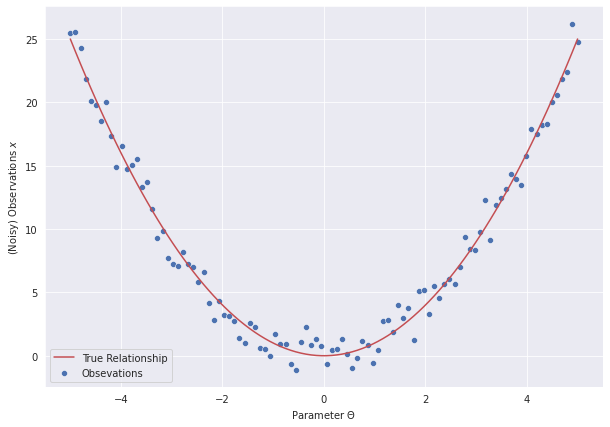

In [9]:
plot_data(data, true_theta, model_func)

# Create Joint Distribution

In [10]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [19]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(ndim)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(data)
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, ndim, prngkey, num_layers=3, width=5,
                                                                   activation='sigmoid', preprocessing=preprocessing)
# num_layers=3, width=10,

In [12]:
# Initialise:
target = Jaxtainer({'mean': 0, 'log_chol_diag': 0})
mse = approx_post.losses.MSE(target)
optimiser = approx_post.optimisers.Adam(lr=5e-3)
_ = optimiser.fit(amortised_dist, mse, data, prngkey, verbose=True)

Loss = 82.18658447265625, Params = Jaxtainer({'W_0': DeviceArray([[-0.75913584, -0.01973878,  2.379394  ,  1.2282702 ,
               0.41732123]], dtype=float32), 'b_0': DeviceArray([-0.00499999, -0.00499999,  0.00499994, -0.00499994,
              0.00499998], dtype=float32), 'W_1': DeviceArray([[-0.06066358, -0.46731135, -0.57081705, -0.40556714,
               0.4293586 ],
             [-0.38993075,  1.165614  , -1.2469593 ,  0.5060226 ,
               0.08742531],
             [-0.46566457,  0.8329989 ,  0.12307294,  0.38274735,
              -0.33791187],
             [-0.21778592,  1.0808867 ,  0.7755841 , -0.42411828,
              -0.75266016],
             [-1.2449256 ,  0.7921966 ,  1.020199  ,  0.57591695,
               1.1448979 ]], dtype=float32), 'b_1': DeviceArray([ 0.005     , -0.00499999,  0.005     ,  0.005     ,
             -0.00499999], dtype=float32), 'W_2': DeviceArray([[ 0.30121264,  0.05195707,  0.86888206, -0.58234495,
              -0.8176523 ],
           

Loss = 53.841495513916016, Params = Jaxtainer({'W_0': DeviceArray([[-0.7341973 ,  0.00526418,  2.3771796 ,  1.2531856 ,
               0.44210002]], dtype=float32), 'b_0': DeviceArray([-0.02968491, -0.02985341,  0.02954085, -0.03017671,
              0.03013454], dtype=float32), 'W_1': DeviceArray([[-0.03563759, -0.49227464, -0.5459254 , -0.38068852,
               0.40846828],
             [-0.36490384,  1.1406493 , -1.2220765 ,  0.53089654,
               0.06682556],
             [-0.44061553,  0.807995  ,  0.14795496,  0.40763122,
              -0.35776892],
             [-0.19275407,  1.0559131 ,  0.800455  , -0.39924893,
              -0.7727647 ],
             [-1.2198808 ,  0.7672093 ,  1.0450988 ,  0.600811  ,
               1.1244588 ]], dtype=float32), 'b_1': DeviceArray([ 0.03003686, -0.02997845,  0.02989452,  0.0298859 ,
             -0.02561293], dtype=float32), 'W_2': DeviceArray([[ 0.27634758,  0.07688848,  0.8940072 , -0.6071551 ,
              -0.8423819 ],
          

Loss = 36.12727737426758, Params = Jaxtainer({'W_0': DeviceArray([[-0.7145165 ,  0.02507086,  2.392184  ,  1.2726091 ,
               0.46095765]], dtype=float32), 'b_0': DeviceArray([-0.048503  , -0.04922989,  0.04788107, -0.05060616,
              0.05033652], dtype=float32), 'W_1': DeviceArray([[-0.01564947, -0.5119427 , -0.5264214 , -0.3612357 ,
               0.40489677],
             [-0.34491172,  1.1209755 , -1.2026047 ,  0.5503321 ,
               0.06419052],
             [-0.42054534,  0.7881811 ,  0.16742109,  0.42709705,
              -0.35802248],
             [-0.1727431 ,  1.0362043 ,  0.81988454, -0.379831  ,
              -0.77389055],
             [-1.1998236 ,  0.7474506 ,  1.0646305 ,  0.6203162 ,
               1.1225812 ]], dtype=float32), 'b_1': DeviceArray([ 0.05006476, -0.04970318,  0.04940841,  0.04936349,
             -0.02816377], dtype=float32), 'W_2': DeviceArray([[ 0.25690925,  0.09647437,  0.9143077 , -0.626243  ,
              -0.86146086],
           

Loss = 22.61688804626465, Params = Jaxtainer({'W_0': DeviceArray([[-0.69544905,  0.04434536,  2.4093072 ,  1.290969  ,
               0.47784853]], dtype=float32), 'b_0': DeviceArray([-0.0657897 , -0.06769948,  0.06423202, -0.07109722,
              0.07036673], dtype=float32), 'W_1': DeviceArray([[ 0.00410447, -0.5309757 , -0.5076852 , -0.34260744,
               0.41380492],
             [-0.32514694,  1.1019279 , -1.183938  ,  0.568922  ,
               0.07394119],
             [-0.40060693,  0.7688308 ,  0.18606994,  0.44574383,
              -0.34623984],
             [-0.15293334,  1.0170759 ,  0.8384593 , -0.36128104,
              -0.7628819 ],
             [-1.179912  ,  0.72821474,  1.0834236 ,  0.63905233,
               1.1331661 ]], dtype=float32), 'b_1': DeviceArray([ 0.06990871, -0.06886119,  0.06816553,  0.06804273,
             -0.01824085], dtype=float32), 'W_2': DeviceArray([[ 0.23827341,  0.11537455,  0.93468374, -0.64407015,
              -0.8793917 ],
           

Loss = 12.948144912719727, Params = Jaxtainer({'W_0': DeviceArray([[-0.6774409 ,  0.06264369,  2.4218783 ,  1.3076056 ,
               0.49171114]], dtype=float32), 'b_0': DeviceArray([-0.08092841, -0.08478495,  0.07811905, -0.09122203,
              0.08984694], dtype=float32), 'W_1': DeviceArray([[ 0.0232884 , -0.5489809 , -0.49013966, -0.3252335 ,
               0.42931476],
             [-0.30594075,  1.0838948 , -1.1665087 ,  0.58623034,
               0.08996472],
             [-0.3810962 ,  0.7502909 ,  0.2034626 ,  0.4631349 ,
              -0.3289552 ],
             [-0.13364354,  0.9989004 ,  0.8557352 , -0.34404197,
              -0.7461108 ],
             [-1.1604469 ,  0.70986223,  1.1010588 ,  0.6565968 ,
               1.1498142 ]], dtype=float32), 'b_1': DeviceArray([ 0.08925106, -0.08707674,  0.08574411,  0.0854966 ,
             -0.00204619], dtype=float32), 'W_2': DeviceArray([[ 0.2208501 ,  0.13323364,  0.95484734, -0.66026276,
              -0.89564633],
          

Loss = 6.562715530395508, Params = Jaxtainer({'W_0': DeviceArray([[-0.66098344,  0.07937041,  2.420817  ,  1.3217902 ,
               0.5018667 ]], dtype=float32), 'b_0': DeviceArray([-0.09349377, -0.09996322,  0.08954693, -0.11017907,
              0.10811623], dtype=float32), 'W_1': DeviceArray([[ 0.04140821, -0.5654075 , -0.4742776 , -0.3096027 ,
               0.44747666],
             [-0.287784  ,  1.0674255 , -1.1508089 ,  0.6017675 ,
               0.10845163],
             [-0.36248446,  0.7331091 ,  0.21910436,  0.47877273,
              -0.3095929 ],
             [-0.11535681,  0.98222464,  0.8712215 , -0.3286051 ,
              -0.72714794],
             [-1.1419033 ,  0.6929407 ,  1.1170392 ,  0.6724523 ,
               1.1688312 ]], dtype=float32), 'b_1': DeviceArray([ 0.10760582, -0.10379715,  0.10164919,  0.10123115,
              0.01661734], dtype=float32), 'W_2': DeviceArray([[ 0.20509197,  0.14952879,  0.9743101 , -0.67434555,
              -0.9098556 ],
           

Loss = 2.771387815475464, Params = Jaxtainer({'W_0': DeviceArray([[-0.64653844,  0.09398788,  2.4082296 ,  1.3331332 ,
               0.5083201 ]], dtype=float32), 'b_0': DeviceArray([-0.10336705, -0.1128432 ,  0.09875299, -0.12717217,
              0.12452916], dtype=float32), 'W_1': DeviceArray([[ 0.05788334, -0.5797688 , -0.46051374, -0.2961108 ,
               0.46607873],
             [-0.27125725,  1.0530089 , -1.1372409 ,  0.6151444 ,
               0.12727104],
             [-0.34536284,  0.7178216 ,  0.2325982 ,  0.4922578 ,
              -0.2900756 ],
             [-0.09865601,  0.9675513 ,  0.8845335 , -0.31535235,
              -0.70799994],
             [-1.1248736 ,  0.6779715 ,  1.1309386 ,  0.68620086,
               1.188174  ]], dtype=float32), 'b_1': DeviceArray([ 0.12438301, -0.11851189,  0.11546107,  0.11483935,
              0.03563591], dtype=float32), 'W_2': DeviceArray([[ 0.19139408,  0.16381279,  0.99241173, -0.68609923,
              -0.92176664],
           

Loss = 0.8470877408981323, Params = Jaxtainer({'W_0': DeviceArray([[-0.6344648 ,  0.10611749,  2.3901289 ,  1.3416854 ,
               0.5117278 ]], dtype=float32), 'b_0': DeviceArray([-0.11073682, -0.12323911,  0.10602543, -0.14155498,
              0.13853921], dtype=float32), 'W_1': DeviceArray([[ 0.07211972, -0.5917145 , -0.4491262 , -0.2850051 ,
               0.48346692],
             [-0.25696006,  1.0410022 , -1.12606   ,  0.6261271 ,
               0.14480494],
             [-0.33038834,  0.7048849 ,  0.24369936,  0.5033444 ,
              -0.2719424 ],
             [-0.08415845,  0.9552682 ,  0.89544666, -0.30450293,
              -0.69023204],
             [-1.1100076 ,  0.6653769 ,  1.1424627 ,  0.69756424,
               1.2062453 ]], dtype=float32), 'b_1': DeviceArray([ 0.1389565 , -0.13082775,  0.12689531,  0.12605935,
              0.05339038], dtype=float32), 'W_2': DeviceArray([[ 0.18003967,  0.17576417,  1.0083833 , -0.6955382 ,
              -0.9312834 ],
          

Loss = 0.11198791116476059, Params = Jaxtainer({'W_0': DeviceArray([[-0.62498885,  0.1155607 ,  2.370998  ,  1.3478224 ,
               0.51316947]], dtype=float32), 'b_0': DeviceArray([-0.11601444, -0.13116454,  0.11159685, -0.15285237,
              0.14965919], dtype=float32), 'W_1': DeviceArray([[ 0.08358905, -0.60103333, -0.44026235, -0.2763952 ,
               0.49809414],
             [-0.2454322 ,  1.0316274 , -1.1173848 ,  0.63462305,
               0.15952538],
             [-0.3182073 ,  0.69466096,  0.25229946,  0.51192695,
              -0.25672105],
             [-0.07243798,  0.9456416 ,  0.90387803, -0.29613107,
              -0.6753487 ],
             [-1.0979322 ,  0.6554661 ,  1.1514456 ,  0.7063986 ,
               1.2214717 ]], dtype=float32), 'b_1': DeviceArray([ 0.15074581, -0.14047953,  0.13579817,  0.13476688,
              0.06832661], dtype=float32), 'W_2': DeviceArray([[ 0.17117704,  0.18512666,  1.0214729 , -0.7026882 ,
              -0.9385256 ],
         

Loss = 0.009203432127833366, Params = Jaxtainer({'W_0': DeviceArray([[-0.6181301 ,  0.12238341,  2.3552384 ,  1.3521117 ,
               0.51372266]], dtype=float32), 'b_0': DeviceArray([-0.11968078, -0.13682936,  0.11561253, -0.16102725,
              0.15775837], dtype=float32), 'W_1': DeviceArray([[ 0.09199047, -0.6077657 , -0.43386215, -0.27018985,
               0.5090052 ],
             [-0.23698811,  1.0248538 , -1.1111317 ,  0.6407384 ,
               0.17048845],
             [-0.3092572 ,  0.6872409 ,  0.25849023,  0.51810217,
              -0.24539573],
             [-0.06384803,  0.93867844,  0.90994126, -0.29011467,
              -0.664285  ],
             [-1.0890595 ,  0.648282  ,  1.1579328 ,  0.7127702 ,
               1.23283   ]], dtype=float32), 'b_1': DeviceArray([ 0.1593945 , -0.14746457,  0.14222564,  0.14104348,
              0.07946353], dtype=float32), 'W_2': DeviceArray([[ 0.16477387,  0.19191109,  1.0311257 , -0.7078084 ,
              -0.9436933 ],
        

Loss = 0.14429646730422974, Params = Jaxtainer({'W_0': DeviceArray([[-0.6137353 ,  0.12682578,  2.3474262 ,  1.3551152 ,
               0.514279  ]], dtype=float32), 'b_0': DeviceArray([-0.12219415, -0.14055245,  0.11818184, -0.16630894,
              0.16292875], dtype=float32), 'W_1': DeviceArray([[ 0.09729269, -0.6121225 , -0.42972326, -0.26616603,
               0.51573235],
             [-0.23167036,  1.0204775 , -1.1070831 ,  0.64470583,
               0.17723756],
             [-0.3036813 ,  0.68250185,  0.26249257,  0.5220973 ,
              -0.23846689],
             [-0.05846288,  0.9342    ,  0.91387194, -0.28621083,
              -0.65748966],
             [-1.0835097 ,  0.6436679 ,  1.1621172 ,  0.7168879 ,
               1.2397845 ]], dtype=float32), 'b_1': DeviceArray([ 0.16482867, -0.15196769,  0.14637803,  0.14510758,
              0.08630853], dtype=float32), 'W_2': DeviceArray([[ 0.1606456 ,  0.19627617,  1.0371335 , -0.7111723 ,
              -0.9470822 ],
         

Loss = 0.31250831484794617, Params = Jaxtainer({'W_0': DeviceArray([[-0.61123186,  0.12958288,  2.3518114 ,  1.3577332 ,
               0.51578075]], dtype=float32), 'b_0': DeviceArray([-0.12426807, -0.14303002,  0.119593  , -0.16948198,
              0.1657627 ], dtype=float32), 'W_1': DeviceArray([[ 0.09996849, -0.6147491 , -0.42724183, -0.2637089 ,
               0.5184785 ],
             [-0.2290201 ,  1.0178598 , -1.1046293 ,  0.6471434 ,
               0.17998432],
             [-0.30111647,  0.67986   ,  0.2649109 ,  0.52452403,
              -0.23576885],
             [-0.05585734,  0.93158734,  0.91628456, -0.28379923,
              -0.6547463 ],
             [-1.0808908 ,  0.64101154,  1.1645955 ,  0.71935904,
               1.2424711 ]], dtype=float32), 'b_1': DeviceArray([ 0.16748446, -0.15462112,  0.14885727,  0.14757225,
              0.08904192], dtype=float32), 'W_2': DeviceArray([[ 0.15820868,  0.19879693,  1.0398474 , -0.71336186,
              -0.94932485],
         

Loss = 0.34273800253868103, Params = Jaxtainer({'W_0': DeviceArray([[-0.6112737,  0.1300088,  2.368434 ,  1.3596014,  0.5183886]],            dtype=float32), 'b_0': DeviceArray([-0.12559767, -0.14374354,  0.11944464, -0.16979453,
              0.16549344], dtype=float32), 'W_1': DeviceArray([[ 0.09918148, -0.6150083 , -0.4270256 , -0.26340467,
               0.5161853 ],
             [-0.22987649,  1.0176415 , -1.10436   ,  0.6474768 ,
               0.17767414],
             [-0.30245516,  0.6800223 ,  0.26516676,  0.52480596,
              -0.2383768 ],
             [-0.05688387,  0.93149966,  0.9166131 , -0.28344056,
              -0.6571076 ],
             [-1.0820928 ,  0.64099884,  1.1647527 ,  0.71958226,
               1.2397976 ]], dtype=float32), 'b_1': DeviceArray([ 0.16649774, -0.15476087,  0.14905384,  0.14784503,
              0.08658897], dtype=float32), 'W_2': DeviceArray([[ 0.15807769,  0.19883454,  1.0382823 , -0.7139276 ,
              -0.9499352 ],
             [-0.

Loss = 0.28141215443611145, Params = Jaxtainer({'W_0': DeviceArray([[-0.6125373 ,  0.12922034,  2.3864522 ,  1.3607496 ,
               0.52106917]], dtype=float32), 'b_0': DeviceArray([-0.12632145, -0.14346674,  0.11859038, -0.1686434 ,
              0.1637615 ], dtype=float32), 'W_1': DeviceArray([[ 0.09687103, -0.6140657 , -0.42794886, -0.26420274,
               0.51188123],
             [-0.23226325,  1.0186329 , -1.1052006 ,  0.64672637,
               0.17334932],
             [-0.30541676,  0.6815166 ,  0.26432773,  0.52399576,
              -0.24305436],
             [-0.05946654,  0.9326575 ,  0.91586983, -0.28414503,
              -0.66149414],
             [-1.0849085 ,  0.6422758 ,  1.163755  ,  0.71867263,
               1.2350376 ]], dtype=float32), 'b_1': DeviceArray([ 0.16393971, -0.15364954,  0.14810593,  0.14700231,
              0.0820867 ], dtype=float32), 'W_2': DeviceArray([[ 0.15908687,  0.19765487,  1.0349553 , -0.71359044,
              -0.9496492 ],
         

Loss = 0.1892220675945282, Params = Jaxtainer({'W_0': DeviceArray([[-0.6144126 ,  0.12784928,  2.4056902 ,  1.3616612 ,
               0.5239477 ]], dtype=float32), 'b_0': DeviceArray([-0.12683225, -0.1427375 ,  0.11740623, -0.1667622 ,
              0.16128182], dtype=float32), 'W_1': DeviceArray([[ 0.09374658, -0.6125331 , -0.42942712, -0.26553237,
               0.5064178 ],
             [-0.23547187,  1.0202211 , -1.1065781 ,  0.6454553 ,
               0.16786066],
             [-0.3092737 ,  0.68369424,  0.26295963,  0.5226579 ,
              -0.24893987],
             [-0.06289416,  0.93443954,  0.9146127 , -0.28535822,
              -0.66705424],
             [-1.0886089 ,  0.64420414,  1.1621907 ,  0.7172102 ,
               1.2290572 ]], dtype=float32), 'b_1': DeviceArray([ 0.16053054, -0.15191434,  0.1465987 ,  0.14561859,
              0.07639468], dtype=float32), 'W_2': DeviceArray([[ 0.16065875,  0.19587356,  1.0306398 , -0.7128562 ,
              -0.9489524 ],
          

Loss = 0.10304843634366989, Params = Jaxtainer({'W_0': DeviceArray([[-0.6165232 ,  0.12622087,  2.4241433 ,  1.3623693 ,
               0.52673155]], dtype=float32), 'b_0': DeviceArray([-0.12718502, -0.14178547,  0.11613555, -0.16454631,
              0.1585112 ], dtype=float32), 'W_1': DeviceArray([[ 0.09035222, -0.61074644, -0.43113628, -0.26708972,
               0.5006002 ],
             [-0.23894958,  1.0220642 , -1.1081829 ,  0.6439587 ,
               0.16201496],
             [-0.31339687,  0.6861401 ,  0.26136822,  0.52109444,
              -0.25518295],
             [-0.06658964,  0.93648094,  0.91313344, -0.28679425,
              -0.6729743 ],
             [-1.092581  ,  0.6463982 ,  1.1603935 ,  0.71551543,
               1.2227184 ]], dtype=float32), 'b_1': DeviceArray([ 0.15684828, -0.14991704,  0.1448591 ,  0.14400434,
              0.07034327], dtype=float32), 'W_2': DeviceArray([[ 0.16245706,  0.1938477 ,  1.0260341 , -0.71192765,
              -0.9480672 ],
         

Loss = 0.042591266334056854, Params = Jaxtainer({'W_0': DeviceArray([[-0.6185659 ,  0.12460263,  2.4403696 ,  1.3629025 ,
               0.5291731 ]], dtype=float32), 'b_0': DeviceArray([-0.12741783, -0.14079624,  0.11495557, -0.16234067,
              0.15584035], dtype=float32), 'W_1': DeviceArray([[ 0.08712365, -0.6089832 , -0.4328125 , -0.26862726,
               0.49512142],
             [-0.24225412,  1.0238798 , -1.1097633 ,  0.64247686,
               0.15650633],
             [-0.31728593,  0.68851155,  0.25980178,  0.51955116,
              -0.26105538],
             [-0.07009209,  0.9384802 ,  0.91166925, -0.28822047,
              -0.6785552 ],
             [-1.0963358 ,  0.6485389 ,  1.1586355 ,  0.71384966,
               1.2167608 ]], dtype=float32), 'b_1': DeviceArray([ 0.15335578, -0.14795709,  0.14315371,  0.14241281,
              0.06464682], dtype=float32), 'W_2': DeviceArray([[ 0.16421375,  0.19188043,  1.0216894 , -0.71099305,
              -0.9471566 ],
        

Loss = 0.010838852263987064, Params = Jaxtainer({'W_0': DeviceArray([[-0.6203344 ,  0.12318195,  2.4535668 ,  1.3632932 ,
               0.531131  ]], dtype=float32), 'b_0': DeviceArray([-0.12756689, -0.13990471,  0.1139688 , -0.16038619,
              0.15352356], dtype=float32), 'W_1': DeviceArray([[ 0.08435716, -0.6074366 , -0.43427566, -0.26997456,
               0.49043143],
             [-0.2450853 ,  1.0254716 , -1.1111465 ,  0.64117545,
               0.15178622],
             [-0.32060546,  0.6905739 ,  0.25842947,  0.51819664,
              -0.2660851 ],
             [-0.07309007,  0.94022846,  0.9103828 , -0.28947634,
              -0.6833415 ],
             [-1.0995431 ,  0.6504057 ,  1.157102  ,  0.7123923 ,
               1.2116635 ]], dtype=float32), 'b_1': DeviceArray([ 0.1503669 , -0.14624259,  0.14166464,  0.14101838,
              0.05976935], dtype=float32), 'W_2': DeviceArray([[ 0.16574219,  0.1901684 ,  1.0179851 , -0.71015877,
              -0.9463465 ],
        

Loss = 0.00012056665582349524, Params = Jaxtainer({'W_0': DeviceArray([[-0.6222274 ,  0.12166245,  2.4671426 ,  1.363692  ,
               0.53304124]], dtype=float32), 'b_0': DeviceArray([-0.12769543, -0.13892867,  0.11293627, -0.1582616 ,
              0.15104143], dtype=float32), 'W_1': DeviceArray([[ 0.08141164, -0.6057701 , -0.4358477 , -0.27142563,
               0.48544282],
             [-0.24810348,  1.0271887 , -1.112637  ,  0.63976985,
               0.14675441],
             [-0.3241462 ,  0.6927964 ,  0.2569451 ,  0.5167294 ,
              -0.2714592 ],
             [-0.07629078,  0.94211644,  0.9089904 , -0.29083773,
              -0.6884568 ],
             [-1.1029586 ,  0.6524153 ,  1.1554514 ,  0.7108203 ,
               1.2062304 ]], dtype=float32), 'b_1': DeviceArray([ 0.14718325, -0.14439563,  0.14006248,  0.13951467,
              0.0545733 ], dtype=float32), 'W_2': DeviceArray([[ 0.16738436,  0.18833287,  1.0140462 , -0.709259  ,
              -0.94546235],
      

Loss = 0.0031456633005291224, Params = Jaxtainer({'W_0': DeviceArray([[-0.62294674,  0.12110441,  2.4723527 ,  1.3638806 ,
               0.5336702 ]], dtype=float32), 'b_0': DeviceArray([-0.12775093, -0.13856174,  0.11253682, -0.1574522 ,
              0.15009363], dtype=float32), 'W_1': DeviceArray([[ 0.08028962, -0.6051407 , -0.43644318, -0.27197492,
               0.48353794],
             [-0.24925852,  1.0278405 , -1.113204  ,  0.63923526,
               0.14482316],
             [-0.3255152 ,  0.6936519 ,  0.2563741 ,  0.5161651 ,
              -0.27353913],
             [-0.07752425,  0.94283956,  0.9084569 , -0.29135936,
              -0.6904322 ],
             [-1.1042695 ,  0.653181  ,  1.1548214 ,  0.7102204 ,
               1.2041396 ]], dtype=float32), 'b_1': DeviceArray([ 0.14596558, -0.14369482,  0.13945325,  0.13894302,
              0.05258052], dtype=float32), 'W_2': DeviceArray([[ 0.1680085 ,  0.18763366,  1.0125407 , -0.708917  ,
              -0.9451288 ],
       

Loss = 0.006325752940028906, Params = Jaxtainer({'W_0': DeviceArray([[-0.6232761 ,  0.12088124,  2.475038  ,  1.3640357 ,
               0.5338674 ]], dtype=float32), 'b_0': DeviceArray([-0.12779792, -0.13840851,  0.11233088, -0.15709528,
              0.1496577 ], dtype=float32), 'W_1': DeviceArray([[ 0.0797651 , -0.60486406, -0.4367099 , -0.27221906,
               0.48264858],
             [-0.24980576,  1.0281314 , -1.1134603 ,  0.638995  ,
               0.14390953],
             [-0.32618594,  0.6940544 ,  0.25610766,  0.51590276,
              -0.27454707],
             [-0.0781209 ,  0.94317234,  0.90821195, -0.29159823,
              -0.6913818 ],
             [-1.1048983 ,  0.6535294 ,  1.1545326 ,  0.70994663,
               1.2031409 ]], dtype=float32), 'b_1': DeviceArray([ 0.14538881, -0.14338142,  0.13917738,  0.13868564,
              0.05163886], dtype=float32), 'W_2': DeviceArray([[ 0.16829275,  0.18731505,  1.0118252 , -0.70876825,
              -0.9449831 ],
        

Loss = 0.007149899378418922, Params = Jaxtainer({'W_0': DeviceArray([[-0.6232952 ,  0.12092675,  2.475794  ,  1.3641711 ,
               0.53373307]], dtype=float32), 'b_0': DeviceArray([-0.12784292, -0.13842858,  0.11227417, -0.1571015 ,
              0.14962712], dtype=float32), 'W_1': DeviceArray([[ 0.07971393, -0.60486966, -0.43671438, -0.27221933,
               0.48256013],
             [-0.24987172,  1.028134  , -1.1134683 ,  0.6389901 ,
               0.14379866],
             [-0.32630545,  0.6940963 ,  0.25608426,  0.51588154,
              -0.27470997],
             [-0.07821386,  0.9431933 ,  0.9081974 , -0.2916108 ,
              -0.691522  ],
             [-1.104988  ,  0.6535447 ,  1.1545157 ,  0.7099333 ,
               1.2030026 ]], dtype=float32), 'b_1': DeviceArray([ 0.14531934, -0.14337766,  0.13916744,  0.13867943,
              0.05152612], dtype=float32), 'W_2': DeviceArray([[ 0.16830564,  0.18729796,  1.0117351 , -0.7087711 ,
              -0.94499046],
        

Loss = 0.0058121271431446075, Params = Jaxtainer({'W_0': DeviceArray([[-0.6230976 ,  0.12116049,  2.475216  ,  1.3642938 ,
               0.5333677 ]], dtype=float32), 'b_0': DeviceArray([-0.12788671, -0.13856994,  0.11232062, -0.1573632 ,
              0.1498814 ], dtype=float32), 'W_1': DeviceArray([[ 0.07999257, -0.605073  , -0.43653542, -0.27204895,
               0.48303345],
             [-0.2496024 ,  1.0279346 , -1.1133028 ,  0.6391499 ,
               0.14425087],
             [-0.32604128,  0.69388604,  0.25623077,  0.5160291 ,
              -0.2742804 ],
             [-0.07795607,  0.94299614,  0.90834415, -0.29146504,
              -0.6910946 ],
             [-1.1047021 ,  0.65332705,  1.1546892 ,  0.710102  ,
               1.2034678 ]], dtype=float32), 'b_1': DeviceArray([ 0.14560321, -0.14359069,  0.13934347,  0.13884889,
              0.05199479], dtype=float32), 'W_2': DeviceArray([[ 0.16812932,  0.18749277,  1.01208   , -0.7088827 ,
              -0.9451034 ],
       

Loss = 0.0035874692257493734, Params = Jaxtainer({'W_0': DeviceArray([[-0.62277776,  0.1214991 ,  2.473855  ,  1.3644061 ,
               0.5328683 ]], dtype=float32), 'b_0': DeviceArray([-0.12792821, -0.1387782 ,  0.11242717, -0.1577654 ,
              0.15029427], dtype=float32), 'W_1': DeviceArray([[ 0.08045795, -0.60538644, -0.43625388, -0.27178335,
               0.48382148],
             [-0.24914324,  1.0276226 , -1.1130404 ,  0.6394015 ,
               0.14501843],
             [-0.3255593 ,  0.6935347 ,  0.2564722 ,  0.51627076,
              -0.27351856],
             [-0.07749949,  0.9426773 ,  0.90858084, -0.29123107,
              -0.6903492 ],
             [-1.1042033 ,  0.6529792 ,  1.1549689 ,  0.71037257,
               1.2042716 ]], dtype=float32), 'b_1': DeviceArray([ 0.14608733, -0.14392455,  0.13962348,  0.13911642,
              0.05278919], dtype=float32), 'W_2': DeviceArray([[ 0.16784666,  0.18780552,  1.0126721 , -0.7090528 ,
              -0.945276  ],
       

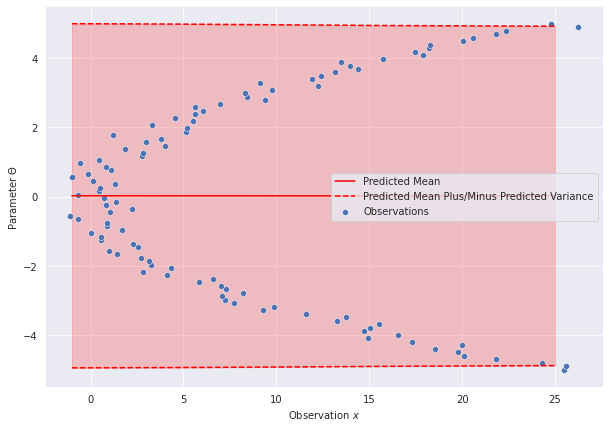

In [20]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [21]:
prngkey = jax.random.PRNGKey(20)
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=50)

Loss = 0.002407959196716547, Params = Jaxtainer({'W_0': DeviceArray([[-0.6644612 ,  0.07481819,  2.2882612 ,  1.3202646 ,
               0.31276798]], dtype=float32), 'b_0': DeviceArray([ 0.09827868, -0.05528928, -0.09289266, -0.09640972,
             -0.09882266], dtype=float32), 'W_1': DeviceArray([[ 0.0333126 , -0.56113243, -0.4769473 , -0.31113964,
               0.33989123],
             [-0.48525354,  1.0729637 , -1.3509947 ,  0.40154305,
               0.1902684 ],
             [-0.57024795,  0.93621594,  0.01826975,  0.2778511 ,
              -0.2334801 ],
             [-0.3222046 ,  1.181897  ,  0.6708393 , -0.5289839 ,
              -0.6483727 ],
             [-1.3486311 ,  0.7033539 ,  0.9156448 ,  0.47115287,
               1.2487373 ]], dtype=float32), 'b_1': DeviceArray([-0.09635653, -0.0987666 , -0.09954624, -0.09975627,
              0.09896234], dtype=float32), 'W_2': DeviceArray([[ 0.20710388,  0.14571539,  0.96099263, -0.6750066 ,
              -0.898985  ],
        

Loss = 0.002369215479120612, Params = Jaxtainer({'W_0': DeviceArray([[-0.46746004,  0.45795357,  2.401482  ,  1.6228105 ,
               0.47430748]], dtype=float32), 'b_0': DeviceArray([-0.07429518, -0.30037305, -0.20386508, -0.07909329,
             -0.42425328], dtype=float32), 'W_1': DeviceArray([[ 0.3457453 , -0.9029267 , -0.19008437, -0.03826002,
               0.05262326],
             [-0.3274814 ,  0.8633043 , -1.2994707 ,  0.4377632 ,
              -0.0620033 ],
             [-0.72386277,  1.0990078 , -0.20046845,  0.04709767,
              -0.32841793],
             [-0.3873803 ,  1.2098328 ,  0.48629665, -0.72397095,
              -0.80462134],
             [-1.2448272 ,  0.53664386,  0.8601195 ,  0.40397078,
               1.0207021 ]], dtype=float32), 'b_1': DeviceArray([ 0.09940824, -0.34796265, -0.02440492, -0.03931502,
             -0.16003662], dtype=float32), 'W_2': DeviceArray([[-0.05552001,  0.38386393,  0.7757853 , -0.93699193,
              -1.1780287 ],
        

Loss = 0.0024781948886811733, Params = Jaxtainer({'W_0': DeviceArray([[-0.68639445,  0.84752864,  2.7550032 ,  1.9883916 ,
               0.82247734]], dtype=float32), 'b_0': DeviceArray([-0.00831601, -0.48414865, -0.2062516 , -0.0689438 ,
             -0.71292496], dtype=float32), 'W_1': DeviceArray([[ 0.6189367 , -1.2102945 , -0.17619188,  0.04294372,
              -0.14200458],
             [-0.41293743,  0.85896546, -1.4561698 ,  0.22232717,
              -0.2629446 ],
             [-1.0161865 ,  1.3726231 , -0.44007602, -0.25927114,
              -0.49074128],
             [-0.6464966 ,  1.4322075 ,  0.2505508 , -1.0184897 ,
              -0.9886806 ],
             [-1.3622422 ,  0.56887966,  0.68181306,  0.16951212,
               0.8309065 ]], dtype=float32), 'b_1': DeviceArray([ 0.17999935, -0.51023936, -0.16831028, -0.18458295,
             -0.35779715], dtype=float32), 'W_2': DeviceArray([[-0.2548961 ,  0.5377052 ,  0.8801409 , -1.1319208 ,
              -1.414542  ],
       

Loss = 0.0023056920617818832, Params = Jaxtainer({'W_0': DeviceArray([[-1.0430096,  1.2232552,  3.1534216,  2.3873246,  1.2178686]],            dtype=float32), 'b_0': DeviceArray([ 0.30945197, -0.7774395 , -0.47144118, -0.3405076 ,
             -1.0591066 ], dtype=float32), 'W_1': DeviceArray([[ 0.9899301 , -1.5840877 , -0.4097032 ,  0.24446696,
              -0.2005724 ],
             [-0.3192076 ,  0.65867007, -1.5944473 ,  0.07893482,
              -0.39107615],
             [-1.2320886 ,  1.548262  , -0.5595775 , -0.4850511 ,
              -0.622333  ],
             [-0.79264313,  1.4954728 ,  0.11619493, -1.2306954 ,
              -1.1239804 ],
             [-1.3079506 ,  0.39903542,  0.54358095,  0.01157783,
               0.707583  ]], dtype=float32), 'b_1': DeviceArray([ 0.48670965, -0.8470411 , -0.42883387, -0.19520544,
             -0.43892387], dtype=float32), 'W_2': DeviceArray([[-5.9675807e-01,  8.6748803e-01,  1.2119949e+00,
              -1.4526472e+00, -1.7618890e+00],


Loss = 0.002245059236884117, Params = Jaxtainer({'W_0': DeviceArray([[-1.4502642,  1.5919689,  3.5647216,  2.7925467,  1.6265428]],            dtype=float32), 'b_0': DeviceArray([ 0.34226885, -0.7951266 , -0.33537322, -0.2914738 ,
             -1.1002969 ], dtype=float32), 'W_1': DeviceArray([[ 1.3156549 , -1.851905  , -0.7215156 ,  0.3974271 ,
              -0.16010197],
             [-0.49918753,  0.8360691 , -1.5437907 , -0.11912373,
              -0.61569923],
             [-1.5628116 ,  1.8781615 , -0.5028186 , -0.7146673 ,
              -0.90602195],
             [-1.0919018 ,  1.787929  ,  0.1701114 , -1.4565141 ,
              -1.4013526 ],
             [-1.5038413 ,  0.58942837,  0.5778364 , -0.18608493,
               0.48642159]], dtype=float32), 'b_1': DeviceArray([ 0.6523623 , -0.9536457 , -0.6654501 , -0.25788236,
             -0.5238912 ], dtype=float32), 'W_2': DeviceArray([[-0.92559946,  1.1851492 ,  1.6111233 , -1.7106588 ,
              -2.0709875 ],
             [ 0

Loss = 0.0022018172312527895, Params = Jaxtainer({'W_0': DeviceArray([[-1.8287207,  1.9139925,  3.8743746,  3.130532 ,  1.9673185]],            dtype=float32), 'b_0': DeviceArray([ 0.30988523, -0.7223776 , -0.08223546, -0.1313799 ,
             -1.0529938 ], dtype=float32), 'W_1': DeviceArray([[ 1.6514273 , -2.108665  , -1.079583  ,  0.6022385 ,
               0.0748516 ],
             [-0.6975807 ,  1.0469793 , -1.4672302 , -0.28859076,
              -0.8057462 ],
             [-1.858457  ,  2.1824377 , -0.41831478, -0.8993911 ,
              -1.166639  ],
             [-1.3698065 ,  2.07216   ,  0.25401792, -1.6404219 ,
              -1.6520607 ],
             [-1.7126267 ,  0.80792326,  0.642724  , -0.35338733,
               0.29398036]], dtype=float32), 'b_1': DeviceArray([ 0.82129574, -1.0263271 , -0.9363504 , -0.27087462,
             -0.43769544], dtype=float32), 'W_2': DeviceArray([[-1.26992   ,  1.5335753 ,  2.0428708 , -1.9651754 ,
              -2.3690505 ],
             [ 

Loss = 0.0021696474868804216, Params = Jaxtainer({'W_0': DeviceArray([[-1.975131 ,  1.9826684,  3.753776 ,  3.1403062,  2.1194632]],            dtype=float32), 'b_0': DeviceArray([ 0.03573709, -0.4331182 ,  0.29332867,  0.20656171,
             -0.8249373 ], dtype=float32), 'W_1': DeviceArray([[ 1.690669  , -2.0254357 , -1.3210225 ,  0.68353117,
               0.1915951 ],
             [-0.94082195,  1.322755  , -1.3967758 , -0.43728283,
              -1.0092571 ],
             [-2.1351175 ,  2.4921637 , -0.3500408 , -1.0447555 ,
              -1.4227673 ],
             [-1.6498152 ,  2.3825727 ,  0.3259075 , -1.7909412 ,
              -1.9103703 ],
             [-1.9445966 ,  1.0721923 ,  0.6991207 , -0.4912522 ,
               0.10230899]], dtype=float32), 'b_1': DeviceArray([ 0.7518838 , -0.8555136 , -1.1095166 , -0.32925782,
             -0.4461124 ], dtype=float32), 'W_2': DeviceArray([[-1.4863254 ,  1.7239006 ,  2.2706552 , -2.132402  ,
              -2.5489473 ],
             [ 

Loss = 0.0021551325917243958, Params = Jaxtainer({'W_0': DeviceArray([[-1.897654 ,  1.7979647,  3.4165392,  2.8943295,  2.0940917]],            dtype=float32), 'b_0': DeviceArray([-0.31587878, -0.06852306,  0.68592846,  0.588938  ,
             -0.5268802 ], dtype=float32), 'W_1': DeviceArray([[ 1.530867  , -1.7544669 , -1.4545598 ,  0.62700033,
               0.15123665],
             [-1.1908232 ,  1.6297101 , -1.3512286 , -0.5655401 ,
              -1.2243345 ],
             [-2.3655639 ,  2.7814322 , -0.3098279 , -1.1537797 ,
              -1.6611332 ],
             [-1.8999643 ,  2.6895177 ,  0.37083778, -1.9100305 ,
              -2.163485  ],
             [-2.1660821 ,  1.3512003 ,  0.73107153, -0.6010385 ,
              -0.08600512]], dtype=float32), 'b_1': DeviceArray([ 0.5384821 , -0.55281276, -1.2029378 , -0.4438274 ,
             -0.57740766], dtype=float32), 'W_2': DeviceArray([[-1.5761709 ,  1.7697856 ,  2.2944744 , -2.226741  ,
              -2.6187637 ],
             [ 

Loss = 0.0020873993635177612, Params = Jaxtainer({'W_0': DeviceArray([[-1.8392905,  1.6772486,  3.1373591,  2.6923559,  2.0671413]],            dtype=float32), 'b_0': DeviceArray([-0.53980047,  0.13594094,  0.92751503,  0.8290156 ,
             -0.37724343], dtype=float32), 'W_1': DeviceArray([[ 1.4561875 , -1.581944  , -1.5576283 ,  0.67516756,
               0.213387  ],
             [-1.3174922 ,  1.8284123 , -1.3231312 , -0.62969124,
              -1.3492893 ],
             [-2.4777997 ,  2.956236  , -0.28644416, -1.212847  ,
              -1.8049535 ],
             [-2.0276375 ,  2.8827198 ,  0.39744058, -1.9746691 ,
              -2.3180602 ],
             [-2.278069  ,  1.5278504 ,  0.75263745, -0.6605252 ,
              -0.20010304]], dtype=float32), 'b_1': DeviceArray([ 0.43411192, -0.3578517 , -1.2779245 , -0.4614656 ,
             -0.5917892 ], dtype=float32), 'W_2': DeviceArray([[-1.668872  ,  1.8331397 ,  2.3513646 , -2.3114157 ,
              -2.6933844 ],
             [ 

Loss = 0.0020846864208579063, Params = Jaxtainer({'W_0': DeviceArray([[-1.8957738,  1.8001475,  3.0849173,  2.7017841,  2.126452 ]],            dtype=float32), 'b_0': DeviceArray([-0.6160993 ,  0.11753672,  0.999484  ,  0.89075977,
             -0.3774781 ], dtype=float32), 'W_1': DeviceArray([[ 1.5015607 , -1.5732725 , -1.6419995 ,  0.82761973,
               0.3770929 ],
             [-1.3327754 ,  1.903049  , -1.2698474 , -0.6487346 ,
              -1.387891  ],
             [-2.507951  ,  3.038816  , -0.25089264, -1.2419361 ,
              -1.87297   ],
             [-2.0618687 ,  2.9723477 ,  0.43752375, -2.004039  ,
              -2.3868935 ],
             [-2.3085418 ,  1.6110877 ,  0.80316657, -0.6938267 ,
              -0.25616089]], dtype=float32), 'b_1': DeviceArray([ 0.45966512, -0.322421  , -1.3253576 , -0.39130872,
             -0.49081978], dtype=float32), 'W_2': DeviceArray([[-1.7708582 ,  1.9251788 ,  2.4628897 , -2.386297  ,
              -2.7723625 ],
             [ 

Loss = 0.002102728234604001, Params = Jaxtainer({'W_0': DeviceArray([[-1.9021679,  1.8486468,  3.0183237,  2.66986  ,  2.1607428]],            dtype=float32), 'b_0': DeviceArray([-0.65863544,  0.07031275,  1.0145544 ,  0.90701866,
             -0.4376538 ], dtype=float32), 'W_1': DeviceArray([[ 1.5353527 , -1.5352429 , -1.7024149 ,  0.94668925,
               0.4759043 ],
             [-1.2907906 ,  1.9536699 , -1.2116002 , -0.63509476,
              -1.4032528 ],
             [-2.4770498 ,  3.088022  , -0.21674073, -1.2405585 ,
              -1.901324  ],
             [-2.0337193 ,  3.0305254 ,  0.4764918 , -2.0012403 ,
              -2.418774  ],
             [-2.2857819 ,  1.6639128 ,  0.861306  , -0.7002859 ,
              -0.28563312]], dtype=float32), 'b_1': DeviceArray([ 0.4979794 , -0.2734427 , -1.3511631 , -0.31696698,
             -0.42733362], dtype=float32), 'W_2': DeviceArray([[-1.8435272 ,  1.9876564 ,  2.5255342 , -2.4452276 ,
              -2.835748  ],
             [ 1

Loss = 0.002084810985252261, Params = Jaxtainer({'W_0': DeviceArray([[-1.7979048,  1.7298211,  2.842871 ,  2.5032418,  2.1369843]],            dtype=float32), 'b_0': DeviceArray([-0.70435745,  0.05586505,  1.0050863 ,  0.92132056,
             -0.5425795 ], dtype=float32), 'W_1': DeviceArray([[ 1.5168726 , -1.3832871 , -1.7430192 ,  0.9926853 ,
               0.4476436 ],
             [-1.1976129 ,  2.0293832 , -1.179888  , -0.58069086,
              -1.417593  ],
             [-2.3762045 ,  3.1319034 , -0.20411143, -1.1982126 ,
              -1.8979676 ],
             [-1.9378958 ,  3.0927496 ,  0.49187547, -1.9561883 ,
              -2.4280741 ],
             [-2.2095394 ,  1.71609   ,  0.89830387, -0.67014307,
              -0.29744402]], dtype=float32), 'b_1': DeviceArray([ 0.51940304, -0.1320953 , -1.3742898 , -0.25562567,
             -0.458512  ], dtype=float32), 'W_2': DeviceArray([[-1.8762709 ,  2.0006063 ,  2.4989867 , -2.4909897 ,
              -2.8846054 ],
             [ 1

Loss = 0.002069201087579131, Params = Jaxtainer({'W_0': DeviceArray([[-1.67558  ,  1.5781502,  2.6675642,  2.3217368,  2.1143613]],            dtype=float32), 'b_0': DeviceArray([-0.7180083 ,  0.02153092,  0.95084363,  0.90089095,
             -0.69613916], dtype=float32), 'W_1': DeviceArray([[ 1.502958  , -1.2075583 , -1.7730274 ,  1.0318667 ,
               0.37930205],
             [-1.0515844 ,  2.1068237 , -1.1182585 , -0.49926355,
              -1.4211073 ],
             [-2.2180085 ,  3.1693254 , -0.17771545, -1.1292716 ,
              -1.8699702 ],
             [-1.7822559 ,  3.1507967 ,  0.52309436, -1.8821584 ,
              -2.4151654 ],
             [-2.0930276 ,  1.7601246 ,  0.96737695, -0.6248009 ,
              -0.29589528]], dtype=float32), 'b_1': DeviceArray([ 0.56774133,  0.02775898, -1.3763235 , -0.17705485,
             -0.51443106], dtype=float32), 'W_2': DeviceArray([[-1.8952821 ,  1.9966674 ,  2.44248   , -2.5310042 ,
              -2.9335196 ],
             [ 1

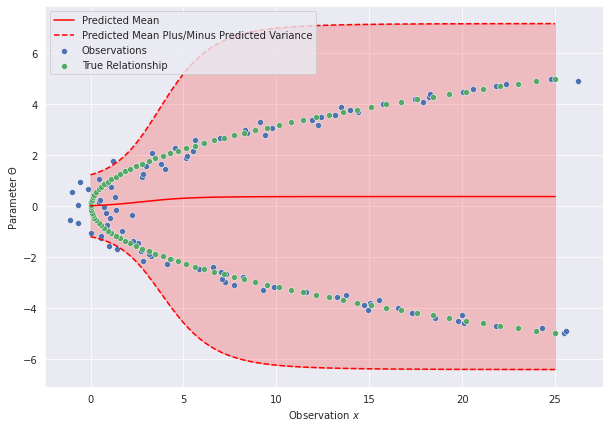

In [22]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model_func)

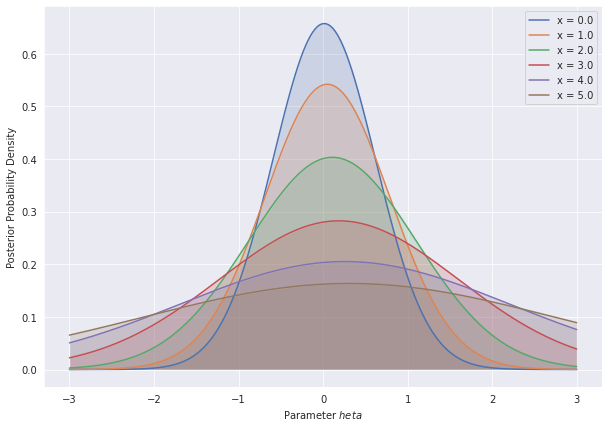

In [23]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)

<AxesSubplot:>

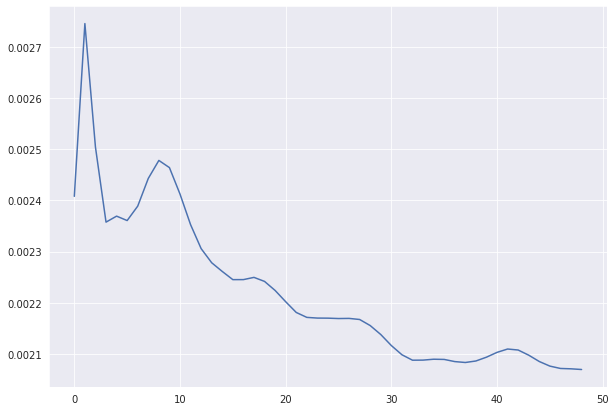

In [24]:
sns.lineplot(x=jnp.arange(len(loss)), y=jnp.array(loss))